# Ensemble check

In [1]:
# enable plotting in notebook
%matplotlib notebook

The results imported here are results from example simulations which are
stored in another Python file. In real-world usage, the results would
either come from the Python interface of the simulation package, from
flat files containing the results, or from package-specific parsers. See
[SimulationData](../simulation_data.rst)
for more details.

In [2]:
from simulation_results import example_simulations

import physical_validation

## Check NVT simulations
To check the configurational quantities in NVT, two (otherwise identical)
simulations run at different temperatures are required.

We start by loading the first NVT simulation of 900 water molecules, which
was performed at 298.15K using velocity-rescale temperature coupling.

In [3]:
simulation_nvt_vrescale_low = example_simulations.get(
    "900 water molecules, NVT at 298K with v-rescale thermostat"
)
num_molecules = 900
simulation_data_nvt_low = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    ensemble=physical_validation.data.EnsembleData(
        ensemble="NVT",
        natoms=num_molecules * 3,
        volume=3.01125 ** 3,
        temperature=298.15,
    ),
    observables=physical_validation.data.ObservableData(
        # This test requires only the potential energy
        potential_energy=simulation_nvt_vrescale_low["potential energy"]
    ),
)

It is not trivial to decide at which temperature to perform a second simulation.
The best results are achieved when the two simulations are close enough to have
good overlap between the distributions, while keeping them far enough apart to
be able to distinguish the physical difference between the distributions from the
statistical error present in simulations.

`physical_validation` offers functionality to compute a rule-of-thumb estimate of
the optimal interval in state point between two functions.
We will now use our first simulation result to get an estimate of where a second
simulation would optimally be located:


In [4]:
physical_validation.ensemble.estimate_interval(
    data=simulation_data_nvt_low,
)

A rule of thumb states that good error recognition can be expected when
spacing the tip of the distributions by about two standard deviations.
Based on this rule, and the assumption that the standard deviation of the
distributions is largely independent of the state point, here's an estimate
for the interval given the current simulation:
Current trajectory: NVT, T = 298.15 K
Suggested interval: dT = 8.4 K


{'dT': 8.44234664462332}

The second simulation available in our example set was performed at 308.15K, which
is reasonably close to the estimate calculated above. Let's load these results:

In [5]:
simulation_nvt_vrescale_high = example_simulations.get(
    "900 water molecules, NVT at 308K with v-rescale thermostat"
)
simulation_data_nvt_high = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    ensemble=physical_validation.data.EnsembleData(
        ensemble="NVT",
        natoms=num_molecules * 3,
        volume=3.01125 ** 3,
        temperature=308.15,
    ),
    observables=physical_validation.data.ObservableData(
        # This test requires only the potential energy
        potential_energy=simulation_nvt_vrescale_high["potential energy"]
    ),
)

Using both simulation data objects, we can now check the ensemble sampled
by our simulations.
We are using `screen=True` to display a result plot on screen.
See argument `filename` to print that same plot to file.

After equilibration, decorrelation and tail pruning, 89.40% (4471 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 90.72% (4537 frames) of original Trajectory 2 remain.
Overlap is 82.4% of trajectory 1 and 73.2% of trajectory 2.
Rule of thumb estimates that dT = 8.6 would be optimal (currently, dT = 10.0)


<IPython.core.display.Javascript object>


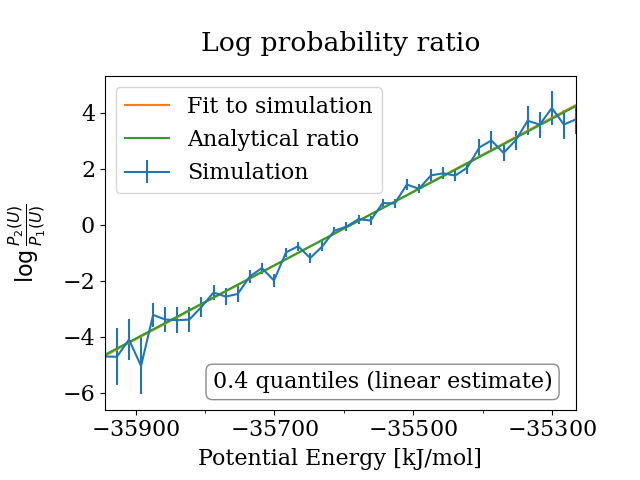

Maximum Likelihood Analysis (analytical error)
Free energy
    477.11477 +/- 10.85952
Estimated slope                  |  True slope
    0.013409  +/- 0.000305       |  0.013091 
    (1.04 quantiles from true slope)
Estimated dT                     |  True dT
    10.2   +/- 0.2               |  10.0  


[1.0426587118546036]

In [6]:
physical_validation.ensemble.check(
    data_sim_one=simulation_data_nvt_low,
    data_sim_two=simulation_data_nvt_high,
    screen=True,
)

By default, the ensemble check is estimating the distance in temperature between the two sampled ensembles using a maximum likelihood approach. This distance estimate is expected to be close to the true value. As a rule of thumb, if the true interval is not within about 2-3 standard deviations of the estimated interval, the trajectory is unlikely to have been sampled from the expected ensemble. The quantiles (number of standard deviations) of difference between the true value and the estimate is returned from the test as a machine-readable test result.

Note that in order to print the plot, the line is also linearly fitted to the simulations. This leads to a slightly different estimate, which explains the difference between the quantiles printed in the plot and in the terminal. As the maximum likelihood estimate is considered to be more exact, it's value is reported on the terminal and used as a return value.

We will now repeat this analysis using the same system, but a simulation which was performed using Berendsen pressure coupling. This temperature coupling method was found not to sample the expected ensemble. We will use this example to illustrate that the `physical_validation` checks are able to pick up this discrepancy in sampling.

Since the simulated system was identical to the one first analyzed, we will simply replace the observable trajectory in our simulation data objects:

In [7]:
simulation_nvt_berendsen_low = example_simulations.get(
    "900 water molecules, NVT at 298K with Berendsen thermostat"
)
simulation_data_nvt_low.observables = physical_validation.data.ObservableData(
    potential_energy=simulation_nvt_berendsen_low["potential energy"]
)
simulation_nvt_berendsen_high = example_simulations.get(
    "900 water molecules, NVT at 308K with Berendsen thermostat"
)
simulation_data_nvt_high.observables = physical_validation.data.ObservableData(
    potential_energy=simulation_nvt_berendsen_high["potential energy"]
)

After equilibration, decorrelation and tail pruning, 89.28% (4465 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 99.80% (4991 frames) of original Trajectory 2 remain.
Overlap is 44.3% of trajectory 1 and 45.6% of trajectory 2.
Rule of thumb estimates that dT = 11.4 would be optimal (currently, dT = 10.0)


<IPython.core.display.Javascript object>


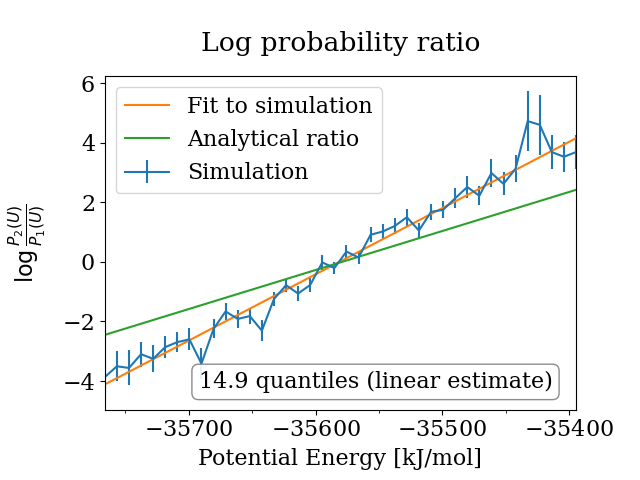

Maximum Likelihood Analysis (analytical error)
Free energy
    808.62976 +/- 22.44259
Estimated slope                  |  True slope
    0.022723  +/- 0.000631       |  0.013091 
    (15.27 quantiles from true slope)
Estimated dT                     |  True dT
    17.4   +/- 0.5               |  10.0  


[15.271945829603142]

In [8]:
physical_validation.ensemble.check(
    data_sim_one=simulation_data_nvt_low,
    data_sim_two=simulation_data_nvt_high,
    screen=True,
)

The check is confirming that the sampled ensemble using the Berendsen thermostat is not behaving as expected when changing the temperature. The reported estimated temperature interval is around 15 standard deviations from the true value, which makes it easy to reject the hypothesis that the potential energy was sampled from the correct ensemble.

## Check NPT simulations
To check the sampled ensemble of the configurational quantities in NPT, we again need two otherwise identical simulations which were performed at slightly different state points (target temperature and / or pressure). The checks can be performed using identical pressure and different temperatures, which will test whether the sampled ensembles exhibit the expected temperature dependence. The checks can also be performed using identical temperature and different pressures, which will in turn test the pressure dependence of the sampled ensemble. Finally, we can also use two simulations which differs in both the target temperature and pressure, combining the two tests into one. Here, we will showcase the last option for a system of 900 water molecules, sampled using velocity-rescale temperature coupling and Parrinello-Rahman pressure coupling. These coupling algorithms were analytically shown to sample the correct distribution, so we will check whether the simulated results fulfill this expectation.

We will start by loading a first simulation, performed at 298.15 K and 1 bar.

In [9]:
simulation_npt_low = example_simulations.get(
    "900 water molecules, NPT at 298K and 1bar, using v-rescale and Parrinello-Rahman"
)
num_molecules = 900
simulation_data_npt_low = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    ensemble=physical_validation.data.EnsembleData(
        ensemble="NPT",
        natoms=num_molecules * 3,
        pressure=1.0,
        temperature=298.15,
    ),
    observables=physical_validation.data.ObservableData(
        # This test requires the potential energy and the volume
        potential_energy=simulation_npt_low["potential energy"],
        volume=simulation_npt_low["volume"],
    ),
)

As in the NVT case, we can use this simulation to have `physical_validation` suggesting a state point to perform the second simulation in.

In [10]:
physical_validation.ensemble.estimate_interval(data=simulation_data_npt_low)

A rule of thumb states that good error recognition can be expected when
spacing the tip of the distributions by about two standard deviations.
Based on this rule, and the assumption that the standard deviation of the
distributions is largely independent of the state point, here's an estimate
for the interval given the current simulation:
Current trajectory: NPT, T = 298.15 K, P = 1.00 bar
Suggested interval:
  Temperature-only: dT = 7.7 K
  Pressure-only: dP = 315.1 bar
  Combined: dT = 7.8 K, dP = 314.8 bar


{'dT': 7.749821872873016,
 'dP': 315.11202690293436,
 'dTdP': [7.763310613476873, 314.82913138004045]}

The rule of thumb suggests that a second state point with a temperature difference of about 7.8 K and a pressure difference of about 315 bar would be optimal. The second simulation which is available in our example set was performed at 308.15 K and 101 bar, so at a distance of 10 K and 100 bar. According to the `physical_validation` estimate, the pressure distance should be a bit further to have optimal error recognition. The check will, however, not be invalid with this choice of state points.

In [11]:
simulation_npt_high = example_simulations.get(
    "900 water molecules, NPT at 308K and 101bar, using v-rescale and Parrinello-Rahman"
)
num_molecules = 900
simulation_data_npt_high = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    ensemble=physical_validation.data.EnsembleData(
        ensemble="NPT",
        natoms=num_molecules * 3,
        pressure=101.0,
        temperature=308.15,
    ),
    observables=physical_validation.data.ObservableData(
        # This test requires the potential energy and the volume
        potential_energy=simulation_npt_high["potential energy"],
        volume=simulation_npt_high["volume"],
    ),
)

Using both simulation data objects, we can now check the ensemble sampled by our simulations. Note that plotting is not available for NPT simulations which differ in both temperature and pressure, since the 2-dimensional plot would be very hard to interpret.

In [12]:
physical_validation.ensemble.check(
    data_sim_one=simulation_data_npt_low,
    data_sim_two=simulation_data_npt_high,
)

After equilibration, decorrelation and tail pruning, 92.46% (4624 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 86.86% (4344 frames) of original Trajectory 2 remain.
Overlap is 72.8% of trajectory 1 and 76.7% of trajectory 2.
Rule of thumb estimates that (dT,dP) = (8.0,320.4) would be optimal (currently, (dT,dP) = (10.0,100.0))
Maximum Likelihood Analysis (analytical error)
Free energy
    521.66706 +/- 13.00986
Estimated slope                  |  True slope
    0.012963  +/- 0.000301       |  0.013091 
    (0.42 quantiles from true slope)
    -2.232868 +/- 0.157176       |  -2.349681
    (0.74 quantiles from true slope)
Estimated dT                     |  True dT
    9.9    +/- 0.2               |  10.0  
Estimated dP                     |  True dP
    93.5   +/- 6.6               |  98.3  


array([0.42492725, 0.74319977])

The ensemble check now prints both the estimated temperature and pressure intervals. We note that in both cases, the true value is within less than a standard deviation, which means that the null hypothesis of sampling the expected ensemble stands.

It's worth noting that the true pressure difference is given as 98.3 bar rather than 100 bar. When checking simulations which differ in both their pressure and temperature, the pressure interval can only be approximated since the temperature and pressure are not perfectly separable in the NPT partition function. Please refer to [Merz & Shirts 2018](https://doi.org/10.1371/journal.pone.0202764), eq (18), for details.